# Coregionalized Regression Model (vector-valued regression)

### updated: 17th June 2015

### by Ricardo Andrade-Pacheco

This tutorial will focus on the use and kernel selection of the $\color{firebrick}{\textbf{coregionalized regression}}$ model in GPy.

## Setup

The first thing to do is to set the plots to be interactive and to import GPy.

In [1]:
import pickle
import re
from glob import glob

import geopandas as gpd
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pb
import scipy.cluster.hierarchy as hac
import seaborn as sns
import xarray
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.signal import find_peaks, savgol_filter
from scipy.spatial.distance import pdist
from sentinelhub import (CRS, BBox, DataCollection, Geometry,
                         SentinelHubStatistical,
                         SentinelHubStatisticalDownloadClient, SHConfig,
                         parse_time)
from shapely import wkb
from tqdm.auto import tqdm

For this example we will generate an artificial dataset.

In [2]:
# load meadows layer
df_s1 = pd.read_parquet(
    "./data/S1COH6D/signals/dataset/",
    columns=["TIMESTAMP", "POLY_ID", "VV_VH_INDEX", "VV", "VH"],
    filters=[("LU_LABEL", "=", "PR"), ("MASK", "=", 1.0)],
)
df_s2 = pd.read_parquet(
    './data/S2/signals-crop/dataset/',
    columns=["TIMESTAMP", "POLY_ID", "NDVI", 'CLP', 'CLM', 'OUT_PROBA', 'LU_LABEL'],
    filters=[("LU_LABEL", "=", '5'), ('N_PIXEL', '>', 50)],
).query('(CLP <= 0.54 or CLM <= 0.99) and OUT_PROBA <= 0.5')

s2t = df_s2.groupby('POLY_ID')['TIMESTAMP'].transform('count')
df_s2 = df_s2[(s2t > 15)]

geoms = pd.read_parquet('./data/S2/geometry-crop/dataset/')

pids = list(set(df_s1.POLY_ID.unique()) & set(df_s2.POLY_ID.unique()))


In [3]:
def prepare_timeseries(series, window=21, order=1): 
    if window is None:
        return series
        
    series = series.drop(columns='POLY_ID').set_index('TIMESTAMP')
    dates = series.index.values
    series = series.resample('1D').interpolate()
    series = series.apply(savgol_filter, window_length=window, polyorder=order)
    return series.loc[dates]

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["TIMESTAMP"] = parse_time(single_data["interval"]["from"]).date()
        
        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name.upper()}"
                    if stat_name != "mean":
                        continue
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

In [4]:
def create_groups(df_s1, df_s2, group_size, n_groups):
    pid_list = np.random.choice(pids, group_size * n_groups, replace=False)
    s1p_coh = df_s1.query("POLY_ID.isin(@pid_list)").sort_values(
        ["POLY_ID", "TIMESTAMP"]
    )
    s2p = df_s2.query("POLY_ID.isin(@pid_list)").sort_values(["POLY_ID", "TIMESTAMP"])

    s1p_coh = (
        s1p_coh.groupby("POLY_ID").apply(prepare_timeseries, window=None).reset_index()
    )

    return s1p_coh, s2p, pid_list.reshape(n_groups, group_size)


def get_group(idx, df_s1, df_s2, pid_array, var="VV_VH_INDEX"):
    subset = pid_array[idx]
    sub_s1, sub_s2 = (
        df_s1[df_s1.POLY_ID.isin(subset)].copy(),
        df_s2[df_s2.POLY_ID.isin(subset)].copy(),
    )

    sub_s1["N_GROUP"] = sub_s1.groupby("POLY_ID").ngroup()
    sub_s1["NX"] = sub_s1.TIMESTAMP.dt.dayofyear + sub_s1["N_GROUP"] * 365

    sub_s2["N_GROUP"] = sub_s2.groupby("POLY_ID").ngroup()
    sub_s2["NX"] = sub_s2.TIMESTAMP.dt.dayofyear + sub_s2["N_GROUP"] * 365

    X1 = sub_s1.NX.values[..., np.newaxis]
    Y1 = sub_s1[var].values[..., np.newaxis]
    X2 = sub_s2.NX.values[..., np.newaxis]
    Y2 = sub_s2.NDVI.values[..., np.newaxis]

    return X1, Y1, X2, Y2


(-0.25, 1.0)

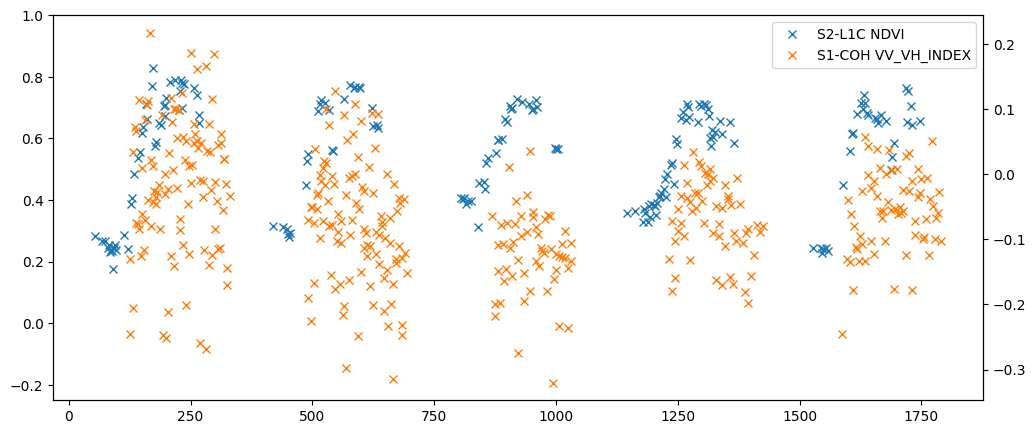

In [5]:
gdx = 0

var='VV_VH_INDEX'
group_size, n_groups = 5, 500
s1p_coh, s2p, pid_array = create_groups(df_s1, df_s2, group_size, n_groups)
X1, Y1, X2, Y2 = get_group(gdx, s1p_coh, s2p, pid_array, var=var)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X2, Y2, "C0x", label="S2-L1C NDVI")

ax.plot([], [], "C1x", label=f"S1-COH {var}")
ax.twinx().plot(X1, Y1, "C1x", label=f"S1-COH {var}")
ax.legend()

ax.set_ylim([-0.25, 1])


In [127]:
def plot_2outputs(m):

    x1, x2 = m.X[m.X[:, 1] == 0, 0], m.X[m.X[:, 1] == 1, 0]
    y1, y2 = m.Y[m.X[:, 1] == 0, 0], m.Y[m.X[:, 1] == 1, 0]
    
    ylim = np.array([[y1.min(), y1.max()], [y2.min(), y2.max()]])
    ylim += 0.25*np.stack([-np.diff(ylim, axis=1), np.diff(ylim, axis=1)], axis=-1).squeeze()
    
    fig, axs = plt.subplots(figsize=(12,8), nrows=2)
    
    #Output 1
    ax1 = axs[0]
    ax1.set_ylim(ylim[0])
    ax1.set_title('Output 1')
    m.plot(fixed_inputs=[(1,0)], which_data_rows=slice(0,len(x1)),ax=ax1)
    
    #Output 2
    ax2 = axs[1]
    ax2.set_ylim(ylim[1])
    ax2.set_title('Output 2')
    m.plot(fixed_inputs=[(1,1)], which_data_rows=slice(len(x1),len(x1)+len(x2)),ax=ax2)
    
    return ax1, ax2

(<AxesSubplot:title={'center':'Output 1'}>,
 <AxesSubplot:title={'center':'Output 2'}>)

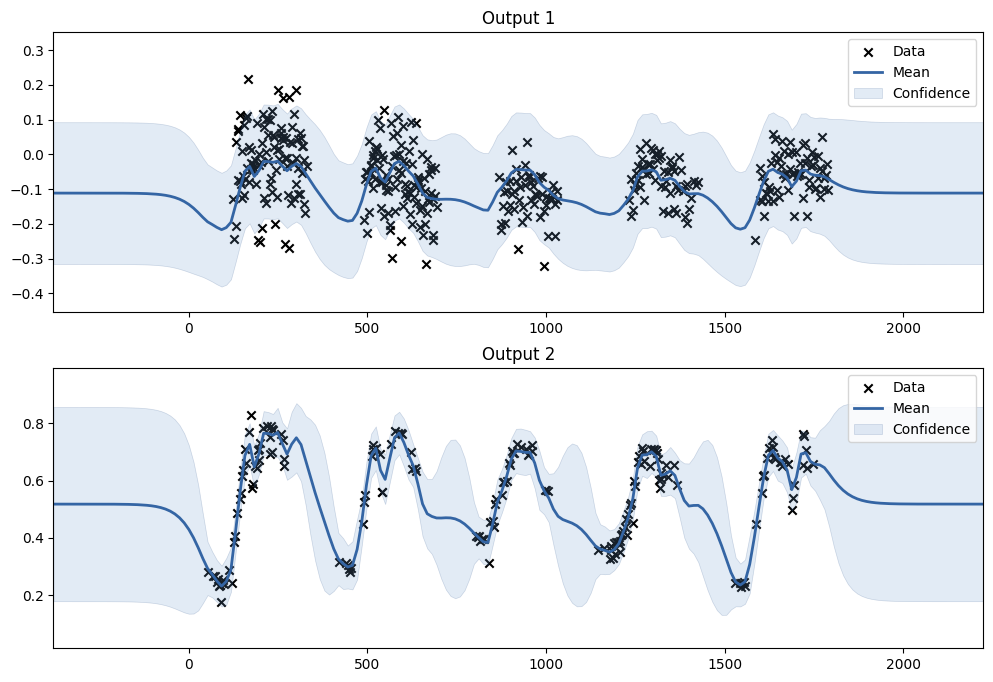

In [129]:
def coreg_optimize(gdx):
    global s1p_coh
    global s2p
    global pid_array

    K = GPy.kern.Bias(1) + GPy.kern.Matern32(input_dim=1)
    LCM = GPy.util.multioutput.LCM(
        input_dim=1, num_outputs=2, kernels_list=[K] * 2
    )

    X1, Y1, X2, Y2 = get_group(gdx, s1p_coh, s2p, pid_array)
    m = GPy.models.GPCoregionalizedRegression([X1, X2], [Y1, Y2], kernel=LCM.copy())
    m.optimize()

    params = {name: m[name].values for name in m.parameter_names()}
    return m, params

m, params = coreg_optimize(0)
plot_2outputs(m)


In [91]:
# models = [coreg_optimize(gdx)[0] for gdx in tqdm(list(range(n_groups)))]
# pickle.dump(models, open('models_500_groups_no_smooth.pkl', 'wb'))
# regex = '.*ICM.*(var|len)'
# names = [name for name in models[0].parameter_names() if re.match(regex, name)]
# df = pd.DataFrame(np.array([m[regex].values() for m in models]), columns=names)
# df.to_parquet('./model_params_500_groups_no_smooth.parquet')


# models = pickle.load(open('./models_500_groups.pkl', 'rb'))
# df = pd.read_parquet('./model_params_500_groups.parquet')
models = pickle.load(open('./models_500_groups_no_smooth.pkl', 'rb'))
df = pd.read_parquet('./model_params_500_groups_no_smooth.parquet')

In [111]:
m = models[0]


{'sum.ICM0.sum.bias.variance': array([0.12286582]),
 'sum.ICM0.sum.Mat32.variance': array([0.01420338]),
 'sum.ICM0.sum.Mat32.lengthscale': array([33.81723358]),
 'sum.ICM0.B.W': array([[-0.14755472],
        [-1.50676446]]),
 'sum.ICM0.B.kappa': array([0.10558777, 0.03511865]),
 'sum.ICM1.sum.bias.variance': array([4.2833391e-07]),
 'sum.ICM1.sum.Mat32.variance': array([3.32927036e-08]),
 'sum.ICM1.sum.Mat32.lengthscale': array([2.16268496]),
 'sum.ICM1.B.W': array([[-0.5300389 ],
        [ 1.24919242]]),
 'sum.ICM1.B.kappa': array([0.0038954 , 0.01763612]),
 'mixed_noise.Gaussian_noise_0.variance': array([0.0025048]),
 'mixed_noise.Gaussian_noise_1.variance': array([0.00100207])}

In [92]:
ndf = (df - df.mean())/df.std()
ndf.head()

,sum.ICM0.sum.bias.variance,sum.ICM0.sum.Mat32.variance,sum.ICM0.sum.Mat32.lengthscale,sum.ICM1.sum.bias.variance,sum.ICM1.sum.Mat32.variance,sum.ICM1.sum.Mat32.lengthscale
0,0.233677,-0.055253,0.072032,-0.069338,-0.160513,-0.911346
1,-0.077782,-0.055018,0.170588,-0.059149,-0.160508,-1.011401
2,-0.070464,-0.055686,-0.217487,-0.069339,1.370857,0.626571
3,-0.077782,0.044422,0.160965,-0.067592,-0.160512,-1.011401
4,-0.074655,-0.055682,0.046837,-0.068585,-0.160454,-1.011401


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24], dtype=int32),
 array([  1,   1,   1,   1,   1,   2,   1,   1,   2,   1,   2, 226,   1,
         19, 231,   1,   1,   1,   1,   1,   1,   1,   1,   1]))

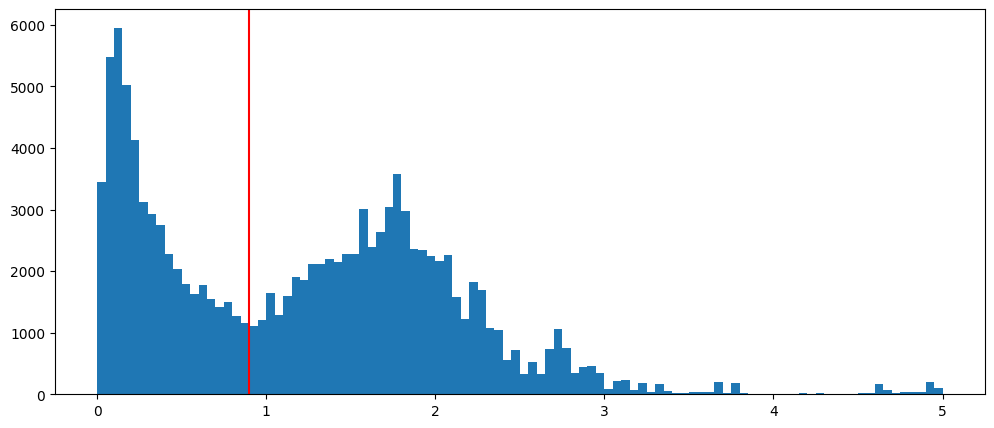

In [93]:
Z = hac.linkage(list(ndf.values), method="average")

fig, ax = plt.subplots(figsize=(12,5))
ax.hist(pdist(ndf.values), bins=100, range=(0, 5));

thr = 0.9
ax.axvline(thr, color='r')
results = fcluster(Z, thr, criterion="distance")

np.unique(results, return_counts=True)

In [58]:
df["cluster_id"] = results
df.loc[df.groupby("cluster_id").cluster_id.transform("count") / len(df) <= 0.1, 'cluster_id'] = -1
fdf = df.query('cluster_id >= 0')

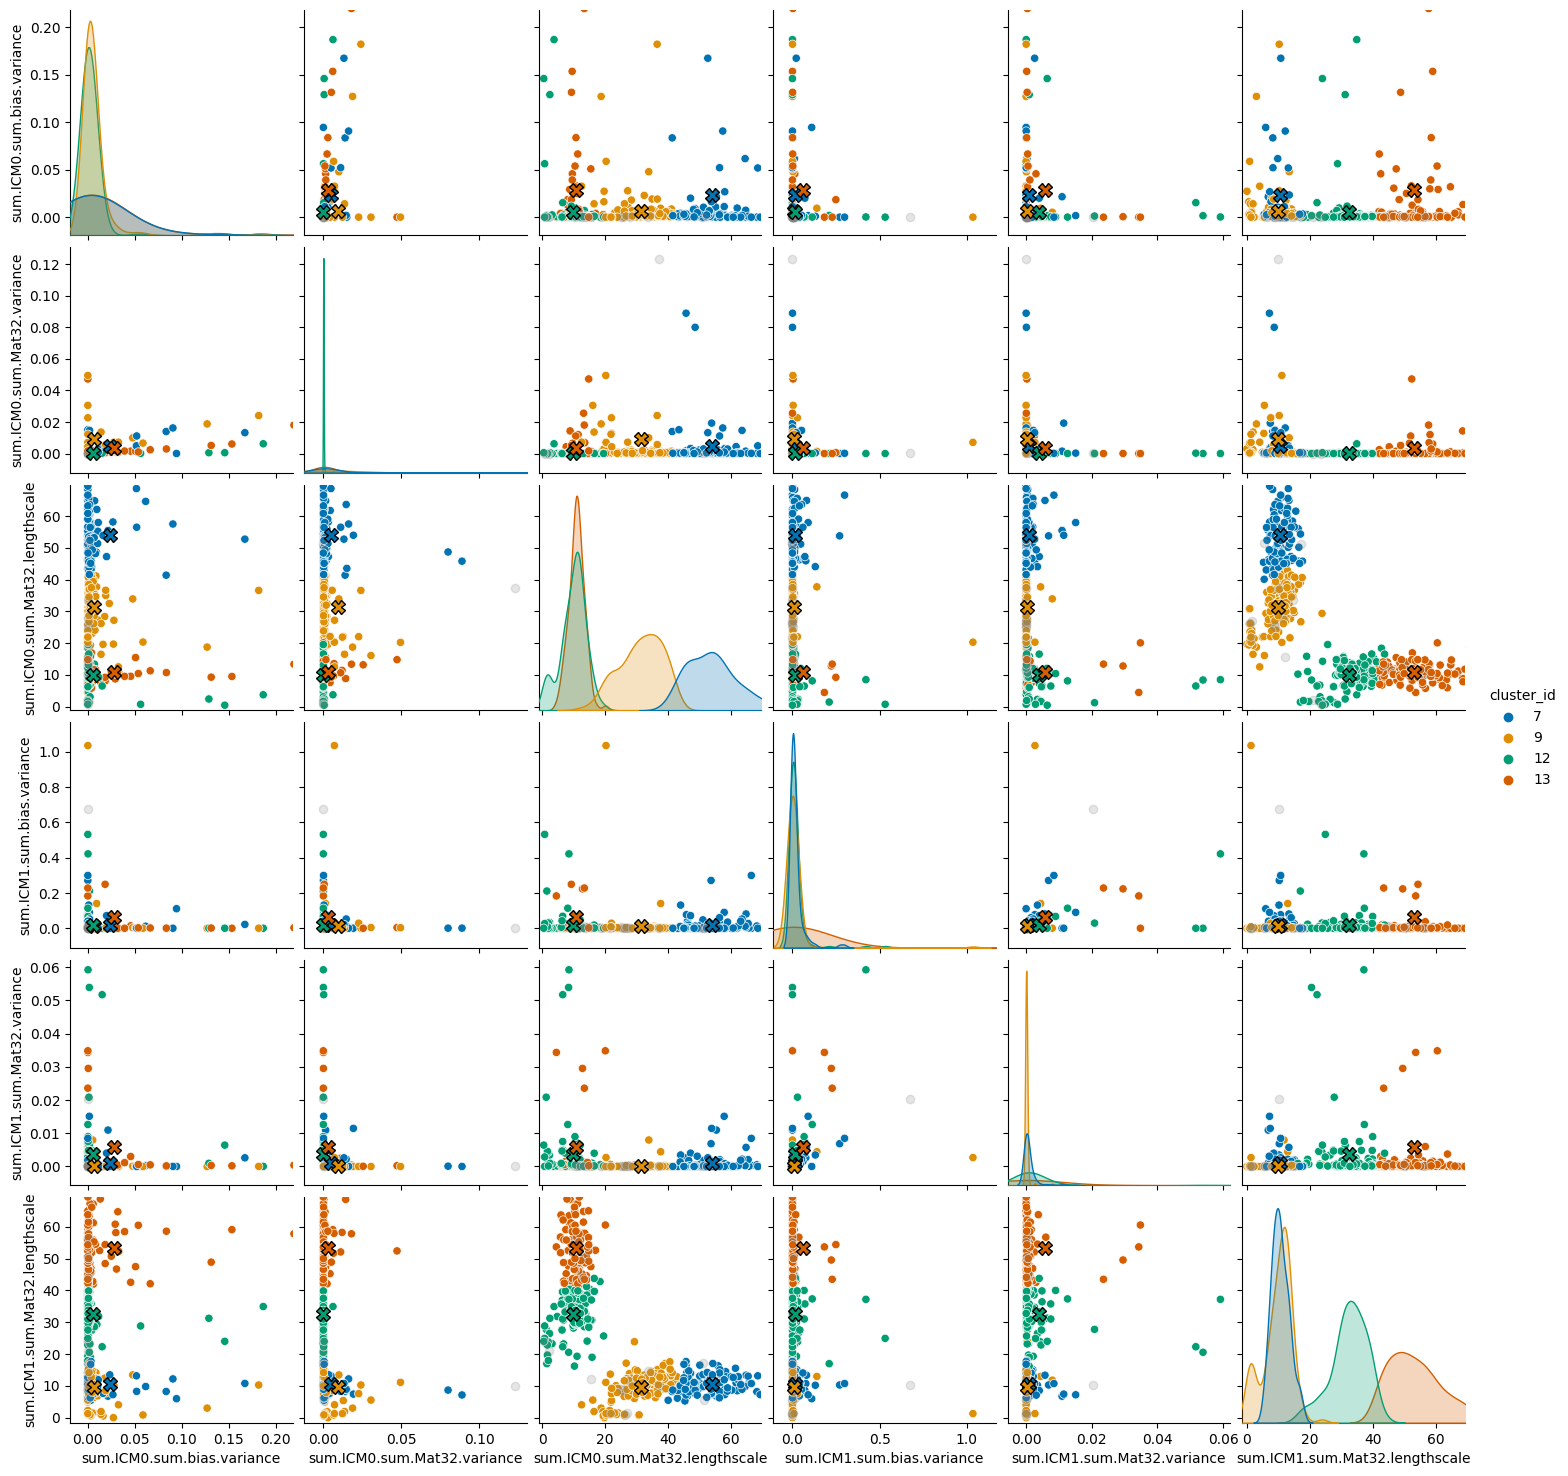

In [59]:
ax_grid = sns.pairplot(fdf, hue="cluster_id", palette="colorblind")

unclust = df.query('cluster_id == -1')

for ax in ax_grid.axes.flatten():
    xlbl = ax.get_xlabel()
    ylbl = ax.get_ylabel()
    if xlbl == "" or ylbl == "":
        continue

    gb = fdf.groupby('cluster_id')
    xm1, xm2, xs, xmin, xmax = gb[xlbl].mean().min(), gb[xlbl].mean().max(), gb[xlbl].std().max(), fdf[xlbl].min(), fdf[xlbl].max()
    ym1, ym2, ys, ymin, ymax = gb[ylbl].mean().min(), gb[ylbl].mean().max(), gb[ylbl].std().max(), fdf[ylbl].min(), fdf[ylbl].max()
    ax.set_xlim([max(xm1-2*xs, xmin-0.2*xs), min(xm2+2*xs, xmax+0.2*xs)])
    ax.set_ylim([max(ym1-2*ys, ymin-0.2*ys), min(ym2+2*ys, ymax+0.2*ys)])

    ax.scatter(unclust[xlbl], unclust[ylbl], alpha=0.2, color='gray')

    for cdx, (_, cdf) in enumerate(fdf.groupby("cluster_id")):
        ax.plot(
            cdf.mean()[xlbl],
            cdf.mean()[ylbl],
            marker="X",
            markeredgecolor="k",
            markersize=10,
            color=sns.color_palette("colorblind")[cdx],
        )


In [90]:
group_size, n_groups = 50, 1
X1,Y1,X2,Y2 = get_group(gdx, *create_groups(df_s1, df_s2, group_size, n_groups))

# Kernel
K = GPy.kern.Bias(1) + GPy.kern.Matern32(input_dim=1)
NLCM = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K.copy()]*2)

c_id = 1
params = fdf.groupby('cluster_id').mean().iloc[c_id].to_dict()
for name, val in params.items():
    NLCM[name[4:]] = val
    NLCM[name[4:]].constrain_fixed()

out_model = GPy.models.GPCoregionalizedRegression([X1, X2],[Y1, Y2], kernel=NLCM.copy())  

In [25]:
# gdx, index = 0, 0
# sX1,sY1,sX2,sY2 = get_group(gdx, *create_groups(df_s1, df_s2, 1, 1))

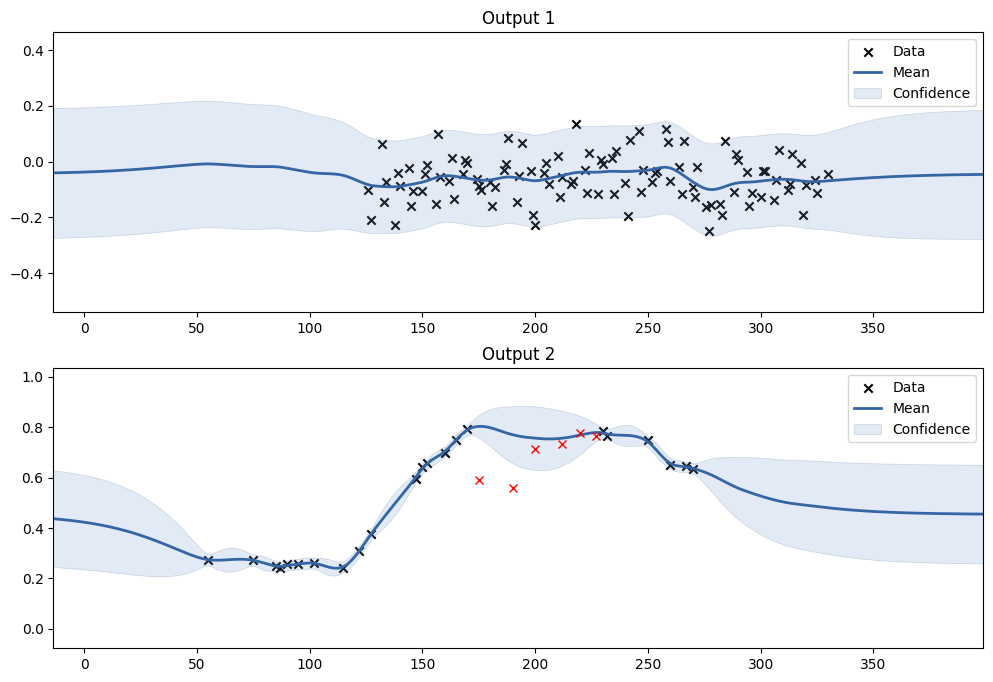

In [89]:
nslc = slice(0, 0)
nslc = slice(np.argmin(abs(sX2-180)), np.argmin(abs(sX2-230)))
NY2 = np.delete(sY2, nslc)[:, np.newaxis]
NX2 = np.delete(sX2, nslc)[:, np.newaxis]

# Kernel
K = GPy.kern.Bias(1) + GPy.kern.Matern32(input_dim=1)
NLCM = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K.copy()]*2, W_rank=1) 
model = GPy.models.GPCoregionalizedRegression([sX1,NX2],[sY1,NY2], kernel=NLCM.copy())  

model['.*ICM'] = out_model['.*ICM']
model['.*ICM'].constrain_fixed()
model.optimize()

ax1, ax2 = plot_2outputs(model, sX1, NX2)
ax2.plot(sX2[nslc], sY2[nslc], 'rx')


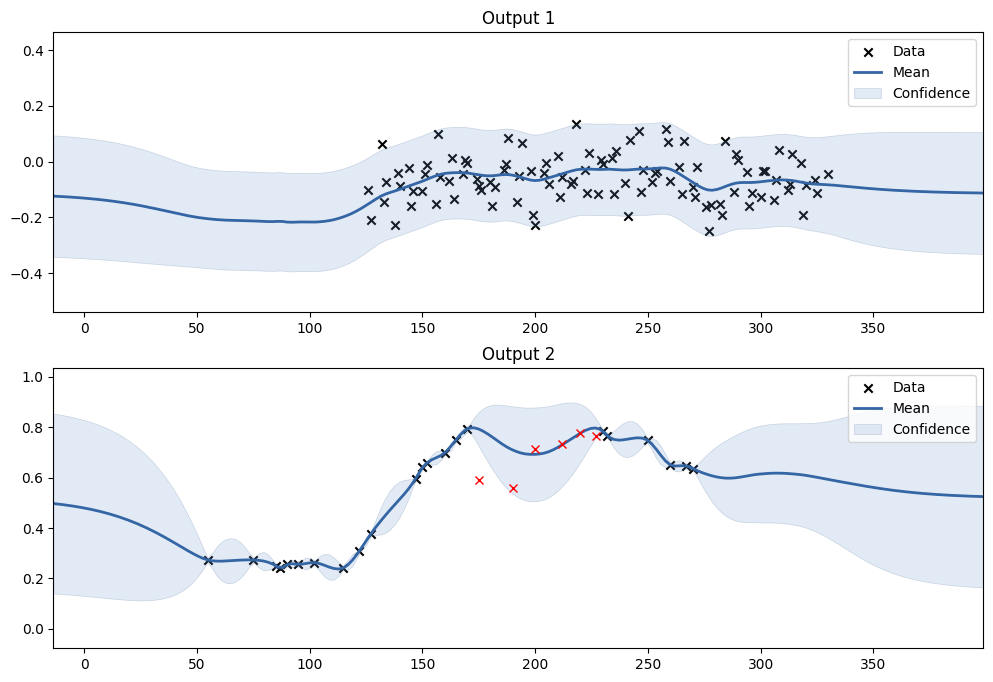

In [87]:
nslc = slice(0, 0)
nslc = slice(np.argmin(abs(sX2-180)), np.argmin(abs(sX2-230)))
NY2 = np.delete(sY2, nslc)[:, np.newaxis]
NX2 = np.delete(sX2, nslc)[:, np.newaxis]

# Kernel
K = GPy.kern.Bias(1) + GPy.kern.Matern32(input_dim=1)
NLCM = GPy.util.multioutput.LCM(input_dim=1, num_outputs=2, kernels_list=[K.copy()]*2)
model = GPy.models.GPCoregionalizedRegression([sX1,NX2],[sY1,NY2], kernel=NLCM.copy())  

idx = np.linalg.norm(df[params.keys()].values - list(params.values()), axis=1).argmin()
model[regex] = models[idx][regex]
model[regex].constrain_fixed()
model.optimize()

ax1, ax2 = plot_2outputs(model, sX1, NX2)
ax2.plot(sX2[nslc], sY2[nslc], 'rx')





Notice that the there are two parameters for the $\color{firebrick}{\textbf{noise variance}}$. Each one corresponds to the noise of each output.

But what is the advantage of this model? Well, the fit of a non-coregionalized model (i.e., two independent models) would look like this:


Name : GP regression
Objective : -427.6224878349136
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat32.variance           |    0.12012625438444872  |      +ve      |        
  Mat32.lengthscale        |      74.81931052341044  |      +ve      |        
  Gaussian_noise.variance  |  1.867423849233157e-46  |      +ve      |        

Name : GP regression
Objective : -34.42965806250608
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  Mat32.variance           |   0.24029267716523933  |      +ve      |        
  Mat32.lengthscale        |     75.10546706991987  |      +ve      |        
  Gaussian_noise.variance  |  0.002721590960530932  |      +ve      |        


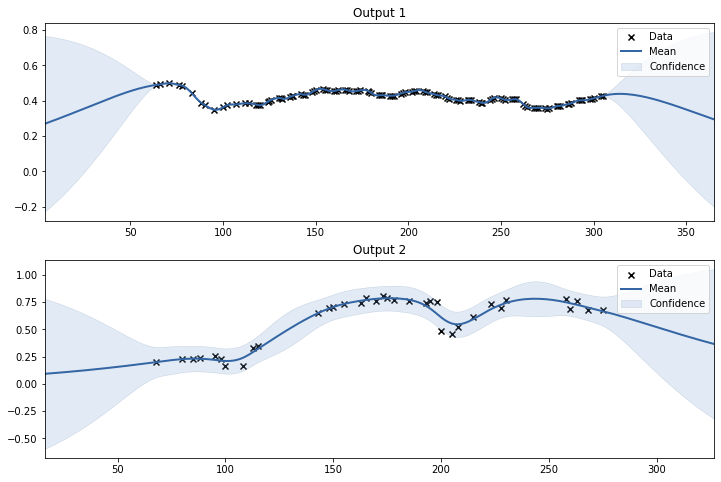

In [163]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=None,ax=ax1)
# ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=None,ax=ax2)
# ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2')

print(m1)
print(m2)

The coregionalized model shares information across outputs, but the independent models cannot do that. In the regions where there is no training data specific to an output the independent models tend to return to the prior assumptions.
In this case, where both outputs have associated patterns, the fit is better with the coregionalized model.

$\color{firebrick}{\textbf{Can we improve the fit in the coregionalization?}}$
Yes, we will have a look at that in the next section.

### Kernel Selection

The data from both outputs is not centered on zero. A way of dealing with outputs of different means or magnitudes is using a 
$\color{firebrick}{\textbf{bias kernel}}$.

This kernel is just changing the mean (constant) of the Gaussian Process being fitted. There is no need to assume any sort of correlation between both means, so we can define ${\bf W} = {\bf 0}$.

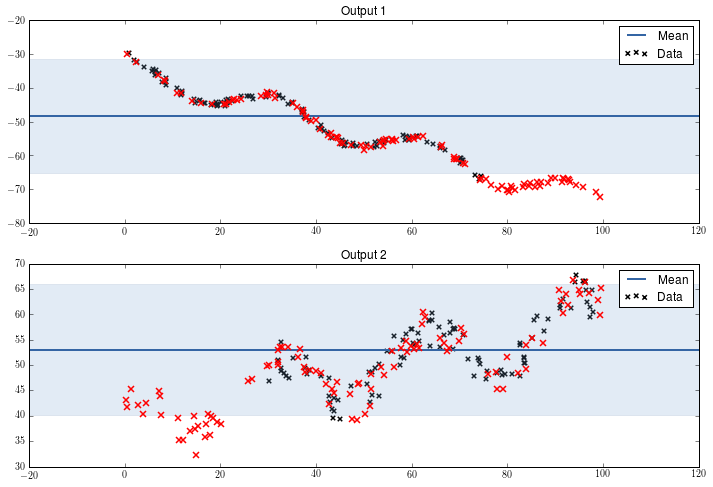

In [ ]:
kernel = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.Bias(input_dim=1))
m = GPy.models.GPCoregionalizedRegression(X_list=[X1,X2],Y_list=[Y1,Y2],kernel=kernel)
m['.*bias.var'].constrain_fixed(1) #B.kappa now encodes the variance.
m['.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

At the moment, our model is only able to explain the mean of the data. However we can notice that there is a deacreasing trend in the first output and and increasent trend in the second one. In this case we can model such a trend with a 
$\color{firebrick}{\textbf{linear kernel}}$.

Since the linear kernel only fits a line with constant slope along the output space, there is no need to assume any correlation between outputs.

We could define our new multiple output kernel as follows:

${\bf K}_{ICM} = {\bf B} \otimes ( {\bf K}_{Bias} + {\bf K}_{Linear} )$.

However, we can also define a more general kernel of the following form:

${\bf K}_{LCM} = {\bf B}_1 \otimes {\bf K}_{Bias} + {\bf B}_2 \otimes {\bf K}_{Linear}$.

GPy has also a function which saves some steps in the definition of 
$\color{firebrick}{\textbf{LCM}}$ kernels.

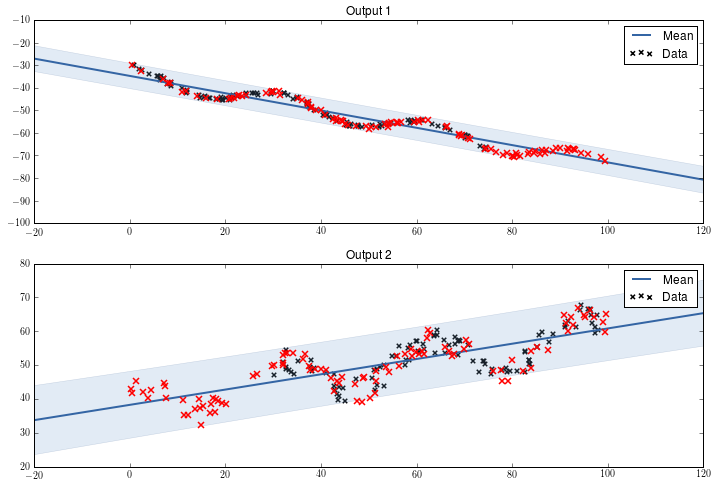

In [ ]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*bias.var'].constrain_fixed(1.)
m['.*W'].constrain_fixed(0)
m['.*linear.var'].constrain_fixed(1.)
m.optimize()
plot_2outputs(m,xlim=(-20,120),ylim=(0,60))

Now we will model the variation along the trend defined by the linear component. We will do this with a Matern-3/2 kernel.

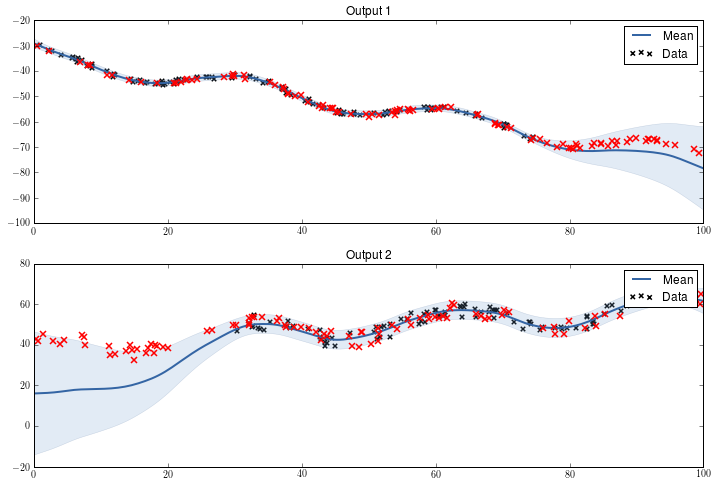

In [ ]:
K1 = GPy.kern.Bias(1)
K2 = GPy.kern.Linear(1)
K3 = GPy.kern.Matern32(1)
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K2,K3])

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=lcm)
m['.*ICM.*var'].unconstrain()
m['.*ICM0.*var'].constrain_fixed(1.)
m['.*ICM0.*W'].constrain_fixed(0)
m['.*ICM1.*var'].constrain_fixed(1.)
m['.*ICM1.*W'].constrain_fixed(0)
m.optimize()
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

### Prediction at new input values

Behind the scenes, this model is using an extended input space with an additional dimension that points at the output each data point belongs to. To make use of the prediction function of GPy, this model needs the input array to have the extended format.

For example if we want to make predictions in the region 100 to 100 for the second output, we need to define the new inputs as follows:

In [ ]:
newX = np.arange(100,110)[:,None]
newX = np.hstack([newX,np.ones_like(newX)])
print(newX)

[[100   1]
 [101   1]
 [102   1]
 [103   1]
 [104   1]
 [105   1]
 [106   1]
 [107   1]
 [108   1]
 [109   1]]


$\color{firebrick}{\textbf{Note:}}$ remember that Python starts counting from zero, so input 1 is actually the second input.

We also need to pass another output to the predict function. This is an array that tells which $\color{firebrick}{\textbf{noise model}}$ is associated to each point to be predicted. This is a dictionary constructed as follows:

In [ ]:
noise_dict = {'output_index':newX[:,1:].astype(int)}

The astype(int) function is to ensure that the values of the dictionary are integers, otherwise the Python complains when using them as indices. Then prediction is command can then be called this way:

In [ ]:
m.predict(newX,Y_metadata=noise_dict)

(array([[64.85926972],
        [64.96750409],
        [65.070204  ],
        [65.16744844],
        [65.25931551],
        [65.34588241],
        [65.42722549],
        [65.50342024],
        [65.57454127],
        [65.64066237]]),
 array([[ 8.8962089 ],
        [11.43325187],
        [15.21013858],
        [20.44905664],
        [27.36105533],
        [36.14639734],
        [46.99490129],
        [60.08627542],
        [75.59044249],
        [93.66785627]]))

$\color{firebrick}{\textbf{Why we need the output_index if we already extend the input space?}}$

In the case of the coregionalized model, each output is automatically assigned a specific Gaussian noise parameter. However, GPy is flexible enough to do more crazy stuff. Think about using an heteroscedastic noise model for each output... Not straightforward, at the moment, but the pieces are in place to handle it.

We can even use different models, not only Gaussian noise. For example, Bernoulli noise or Poisson noise... but that is part of a future notebook. 